In [1]:
import os #Bring Python's operating system interface
from ddgs import DDGS #Bring the DuckDuckGo Search class

In [2]:
os.environ['USER_AGENT'] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'

from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool


In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI #bring the LLM (Gemini)

In [4]:
from langchain.agents import create_agent # create the agent with the tools, llm, and prompt
from langchain_core.prompts import ChatPromptTemplate # prompts that are used to guide the agent

In [5]:
from dotenv import load_dotenv # bring the function that is allowed to read the .env file
load_dotenv() # Loading the necesary environment variables from the .env file

True

In [6]:
from ddgs import DDGS

results = DDGS().text("who is AIMultiple", max_results=2) # create a DDGS object and use the text method to search for the query "who is AIMultiple" with a maximum of 2 results and save it in the results variable
print(results)

[{'title': 'About | AIMultiple', 'href': 'https://aimultiple.com/about', 'body': 'AIMultiple team got together in 2017 to help businesses research, shortlist and evaluate new technology solutions with data-driven insights. AIMultiple reaches a global audience that includes: Business decision makers and their teams, investors and consultants. They leverage AIMultiple to research software products or technology related services. AIMultiple is an independent, 100% employee ...'}, {'title': 'Read Customer Service Reviews of aimultiple.com - Trustpilot', 'href': 'https://www.trustpilot.com/review/aimultiple.com', 'body': "AImultiple is doing a great job offering a bridge for today's business professionals for the future. Really appreciate efforts to put together those information, connections and experiance."}]


In [7]:
results[1]

{'title': 'Read Customer Service Reviews of aimultiple.com - Trustpilot',
 'href': 'https://www.trustpilot.com/review/aimultiple.com',
 'body': "AImultiple is doing a great job offering a bridge for today's business professionals for the future. Really appreciate efforts to put together those information, connections and experiance."}

In [ ]:
@tool
def web_search(query: str, num_results: int = 3) -> str: # The comments down below are for the AI to read
    """
    Use this tool to perform a real-time web search and scrape the content of the top results.
    Useful for getting up-to-date news, documentation, or factual information.
    
    Args:
        query: The search query string.
        num_results: Number of results to search and scrape (default: 3).
                     Keep this low (3-5) to ensure speed.
    
    Returns:
        A formatted string containing titles, URLs, and the full page content of the search results.
    """
    print(f"🔎 Searching and Scraping for: '{query}'...")
    try:
        # 1. Perform the search using DuckDuckGo (Free, no API key required)
        # We use the 'text' backend for standard web results
        results = DDGS().text(query=query, max_results=num_results, region='us-en')
        
        if not results:
            return f"No results found for '{query}'"
        
        formatted_results = [f"--- Search Results for: '{query}' ---\n"]
        
        # 2. Iterate through results and Scrape content
        for i, result in enumerate(results, 1):
            title = result.get('title', 'No title')
            href = result.get('href', '')
            snippet = result.get('body', 'No description available')
            
            print(f"   Processing result {i}: {title[:30]}...")
            
            try:
                # Attempt to scrape the full page content
                loader = WebBaseLoader(href)
                # Set a timeout to prevent hanging on slow sites
                loader.requests_kwargs = {'timeout': 5} 
                docs = loader.load()
                
                # Clean up whitespace for the LLM
                page_content = "\n\n".join([doc.page_content for doc in docs])
                # Limit content length per page to avoid token limits to make it manageable for the LLM
                page_content = page_content[:4000] 
                
                body = f"FULL PAGE CONTENT:\n{page_content}"
            except Exception as e:
                # Fallback to the search snippet if scraping fails
                print(f"   Failed to scrape {href}: {e}")
                body = f"SNIPPET (Scraping Failed):\n{snippet}"
            
            text = f"\nResult {i}:\nTitle: **{title}**\nURL: {href}\n{body}\n{'-'*50}"
            formatted_results.append(text)
        
        return "\n".join(formatted_results)
    
    except Exception as e:
        return f"Error performing search: {str(e)}"

In [20]:
result = web_search.invoke({'query': 'what are the most popular genz terms', 'num_results': 5}) #calling the web_search tool with a query and a number of results 
print(result)

🔎 Searching and Scraping for: 'what are the most popular genz terms'...
   Processing result 1: Glossary of 2020s slang - Wiki...
   Processing result 2: 20 Gen Z slang terms and what ...
   Processing result 3: 50 Gen Z Slang Words, Lingo, P...
   Processing result 4: 20 Fire Gen Z Slang Terms You ...
   Processing result 5: 90+ Gen Z Slang words and how ...
--- Search Results for: 'what are the most popular genz terms' ---


Result 1:
Title: **Glossary of 2020s slang - Wikipedia**
URL: https://en.wikipedia.org/wiki/Glossary_of_2020s_slang
FULL PAGE CONTENT:




Glossary of 2020s slang - Wikipedia



























Jump to content







Main menu





Main menu
move to sidebar
hide



		Navigation
	


Main pageContentsCurrent eventsRandom articleAbout WikipediaContact us





		Contribute
	


HelpLearn to editCommunity portalRecent changesUpload fileSpecial pages



















Search











Search






















Appearance
















Donate

Create accou

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0) #bring the model itself aka the brain of the agent

In [ ]:
tools = [web_search] #the list of our tools

In [12]:
system_prompt = """You are a professional research agent with web_search capability. Follow these steps:

STEP 1: UNDERSTAND THE QUESTION
- Read the user's question carefully
- Identify the main topic and what they want to know

STEP 2: PLAN YOUR SEARCHES
- Think of 3-5 different search queries to cover the topic
- Consider different angles and perspectives

STEP 3: CONDUCT MULTIPLE SEARCHES
- Search #1: General overview search
- Search #2: Specific details search
- Search #3: Recent developments search
- Search #4-5: Additional targeted searches as needed

STEP 4: ANALYZE RESULTS
- Compare information across search results
- Identify key facts and patterns
- Note important URLs for reference

STEP 5: SYNTHESIZE FINDINGS
- Combine information from all searches
- Create a clear, comprehensive answer
- Include source URLs in your response

RULES:
- Always perform at least 3 searches
- Use different keywords for each search
- Focus on recent and reliable sources
- Cite sources with URLs
- Be thorough but concise

EXAMPLE:
User: "What are the latest AI developments?"

Your process:
1. web_search("latest AI developments 2025")
2. web_search("artificial intelligence breakthroughs recent")
3. web_search("new AI models released 2025")
4. Analyze all results
5. Write comprehensive answer with sources

Now research the user's question."""

In [ ]:
agent = create_agent(model=llm, tools=tools, system_prompt=system_prompt) #this is where magic happens. Creating the agent with the model, tools, and system prompt

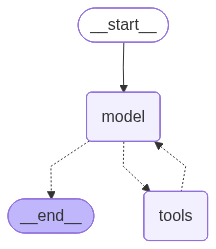

In [14]:
agent

In [ ]:
from langchain_core.messages import HumanMessage  # an agent needs a message not a plain text so we use the HumanMessage class

query = "what are the most popular genz terms ?"

result = agent.invoke({'messages': [HumanMessage(content=query)]}) # let's wake up the agent 

🔎 Searching and Scraping for: 'most popular Gen Z terms'...
   Processing result 1: Top 100+ Gen Z Slang Terms to ...
   Processing result 2: 50 Most Popular Gen Z Slang Wo...
   Processing result 3: 50 Gen Z Slang Words, Lingo, P...
🔎 Searching and Scraping for: 'latest Gen Z slang with meanings'...
   Processing result 1: Glossary of 2020s slang - Wiki...
   Processing result 2: 2026 Teen Slang Dictionary: De...


In [22]:
result

{'messages': [HumanMessage(content='what are the most popular genz terms ?', additional_kwargs={}, response_metadata={}, id='691d3c85-6ff4-49e7-aded-4332065e817d'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"num_results": 3, "query": "most popular Gen Z terms"}'}, '__gemini_function_call_thought_signatures__': {'36bc2363-de1a-4229-ae24-be2797102a17': 'CswHAXLI2nztIRnD+GQ4C2j0BF3lNkSdVPJjpbMa6vSXON7DaSZVgdtRf88E21HG/Ne0e9oSLoFY89hdPoFyku7V7SqEmfr8NhFzKnfSae6/mdqkrNRiR4t3xOHEJ9ml4L+rDn+0JVJawCP4iIrt6CO2qA+ql4x2wvihH6fhebThAxaiCyupulZd2//+HcqQyRgnvobX4XmpfPGJFPy83t+WGJ38rzIABWfppILjdetNG/7wiIkIeSpNJyg0I6vWEydYrSQgR4ZxM8lnXRjfroCTAOj2iTfBPjU06EIXe8KVEUA4BVVx4BK2QwBYVLSk+DDuyoerBCpPZaaFoAmmQbKU4IHUfbn/pzfaJyDWXRKzfFfFlTIlNYqK+fVvVQzWt4N8976gCjXzlVGyRpWAUO6/qApBK88xjBqe6B7AR1dvtWw8qVcCZYFYklAob4xOjVi3IrqoAEHInTuo6n1EIA7fykn8vNvICYKxoL2dPyoebsN99qSbzZ4ZJxQFvv5CbmOq+pYcLZbYfL7ciybeKr5bCiFEgjMQLF/LxNy6qmlT1xP2OIVf9TUGH8tyUKEhXsQgxS5n45KCGl

In [ ]:
result['messages'][-1].pretty_print() # we are getting the last message from the agent and pretty (slayyy) printing it

================================== Ai Message ==================================

[{'type': 'text', 'text': 'Here are some of the most popular Gen Z terms, compiled from various sources, along with their meanings:\n\n**Common Gen Z Terms and Their Meanings:**\n\n*   **Ate / Ate and left no crumbs:** To have performed exceptionally well or to have done something perfectly.\n*   **Aura:** Refers to someone\'s overall vibe, energy, or personality. Can also be used to compliment someone\'s ability or perceived power.\n*   **Based:** Originating from rapper Lil B, it means being yourself and not caring what others think. More recently, it\'s used to express approval or agreement with an opinion, similar to "W."\n*   **Bet:** An enthusiastic agreement or affirmation, similar to "okay" or "yes." It can also mean "you\'re on!"\n*   **Big Yikes:** An exclamation used to express extreme embarrassment or awkwardness, often in response to something cringe-worthy.\n*   **Brainrot:** Refers to conte

In [ ]:
print(result['messages'][-1].content[0]['text']) # just printing the last message without the slayyy part

Here are some of the most popular Gen Z terms, compiled from various sources, along with their meanings:

**Common Gen Z Terms and Their Meanings:**

*   **Ate / Ate and left no crumbs:** To have performed exceptionally well or to have done something perfectly.
*   **Aura:** Refers to someone's overall vibe, energy, or personality. Can also be used to compliment someone's ability or perceived power.
*   **Based:** Originating from rapper Lil B, it means being yourself and not caring what others think. More recently, it's used to express approval or agreement with an opinion, similar to "W."
*   **Bet:** An enthusiastic agreement or affirmation, similar to "okay" or "yes." It can also mean "you're on!"
*   **Big Yikes:** An exclamation used to express extreme embarrassment or awkwardness, often in response to something cringe-worthy.
*   **Brainrot:** Refers to content on the internet, particularly on TikTok, that is perceived as low-quality, nonsensical, or detrimental to one's intelli

In [34]:
# saving process
from datetime import datetime
import json

def save_as_markdown(query, answer, filename=None):
    """Save answer as a markdown file"""
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"agent_answer_{timestamp}.md"
    
    content = f"""# Agent Research Report

## Question
{query}

## Answer
{answer}

---
*Generated at: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}*
"""
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(content)
    
    print(f" Markdown saved to: {filename}")
    return filename

def save_as_json(query, answer, filename=None):
    """Save answer as JSON"""
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"agent_answer_{timestamp}.json"
    
    data = {
        "query": query,
        "answer": answer,
        "timestamp": datetime.now().isoformat(),
        "model": "gemini-2.5-flash"
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    
    print(f"JSON saved to: {filename}")
    return filename

# Extract the answer from the previous result
answer_text = result['messages'][-1].content[0]['text']


In [35]:
save_as_markdown(query, answer_text)

 Markdown saved to: agent_answer_20251224_033658.md


'agent_answer_20251224_033658.md'

In [36]:
save_as_json(query, answer_text)

JSON saved to: agent_answer_20251224_033701.json


'agent_answer_20251224_033701.json'

In [37]:
# Benchmarking Module
import time

class AgentBenchmark:
    """Track performance metrics for the agent"""
    
    def __init__(self):
        self.metrics = {
            'start_time': None,
            'end_time': None,
            'duration': None,
            'num_searches': 0,
            'num_llm_calls': 0,
            'query': None,
            'success': False
        }
    
    def start(self, query):
        """Start benchmarking"""
        self.metrics['start_time'] = time.time()
        self.metrics['query'] = query
        self.metrics['num_searches'] = 0
        self.metrics['num_llm_calls'] = 0
        print(f"  Benchmark started for query: '{query[:50]}...'")
    
    def count_search(self):
        """Increment search counter"""
        self.metrics['num_searches'] += 1
    
    def count_llm_call(self):
        """Increment LLM call counter"""
        self.metrics['num_llm_calls'] += 1
    
    def end(self, success=True):
        """End benchmarking and calculate metrics"""
        self.metrics['end_time'] = time.time()
        self.metrics['duration'] = self.metrics['end_time'] - self.metrics['start_time']
        self.metrics['success'] = success
    
    def get_report(self):
        """Generate benchmark report"""
        duration = self.metrics['duration']
        
        report = f"""
{'='*80}
BENCHMARK REPORT
{'='*80}
Query: {self.metrics['query']}
Status: {'Success' if self.metrics['success'] else ' Failed'}

Performance Metrics:
  • Total Duration: {duration:.2f} seconds
  • Number of Searches: {self.metrics['num_searches']}
  • Estimated LLM Calls: {self.metrics['num_llm_calls']}
  • Average Time per Search: {duration/max(self.metrics['num_searches'], 1):.2f}s

Cost Estimation (Gemini Flash - approximate):
  • Estimated Tokens: ~{self.metrics['num_searches'] * 5000} tokens
  • Estimated Cost: $0.00 (within free tier)
  
Efficiency Score: {self._calculate_efficiency_score()}/10
{'='*80}
"""
        return report
    
    def _calculate_efficiency_score(self):
        """Calculate efficiency score (0-10)"""
        # Lower time and fewer searches = higher score
        duration = self.metrics['duration']
        searches = self.metrics['num_searches']
        
        # Base score on time (faster = better)
        if duration < 10:
            time_score = 10
        elif duration < 20:
            time_score = 8
        elif duration < 30:
            time_score = 6
        else:
            time_score = 4
        
        # Adjust for number of searches (3-5 is optimal)
        if 3 <= searches <= 5:
            search_score = 10
        elif searches < 3:
            search_score = 6  # Too few searches
        else:
            search_score = 8 - (searches - 5)  # Too many searches
        
        return round((time_score + search_score) / 2, 1)
    
    def save_report(self, filename=None):
        """Save benchmark report to file"""
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"benchmark_{timestamp}.txt"
        
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(self.get_report())
        
        print(f" Benchmark report saved to: {filename}")
        return filename

# Create a global benchmark instance
benchmark = AgentBenchmark()


In [38]:
# Benchmarked Agent Runner
def run_with_benchmark(question, save_format=None):
    """
    Run the agent with benchmarking enabled
    
    Args:
        question: The question to research
        save_format: Optional - 'txt', 'md', or 'json' to save answer
    
    Returns:
        Dictionary with answer, metrics, and filenames
    """
    # Start benchmark
    benchmark.start(question)
    
    try:
        # Run the agent
        print(f"\n Agent is researching...\n")
        result = agent.invoke({'messages': [HumanMessage(content=question)]})
        
        # Count searches by looking at messages
        searches = sum(1 for msg in result['messages'] if hasattr(msg, 'name') and msg.name == 'web_search')
        benchmark.metrics['num_searches'] = searches
        benchmark.metrics['num_llm_calls'] = len([m for m in result['messages'] if hasattr(m, 'content')])
        
        # Extract answer
        answer = result['messages'][-1].content[0]['text']
        
        # End benchmark
        benchmark.end(success=True)
        
        # Show benchmark report
        print(benchmark.get_report())
        
        # Optionally save answer
        saved_files = {}
        if save_format:
            if save_format == 'md':
                saved_files['answer'] = save_as_markdown(question, answer)
            elif save_format == 'json':
                saved_files['answer'] = save_as_json(question, answer)
            
            # Save benchmark report
            saved_files['benchmark'] = benchmark.save_report()
        
        return {
            'answer': answer,
            'metrics': benchmark.metrics,
            'files': saved_files
        }
        
    except Exception as e:
        benchmark.end(success=False)
        print(f" Error: {e}")
        print(benchmark.get_report())
        return None



In [39]:
# Running
test_result = run_with_benchmark("what are the most popular genz terms", save_format='md')


  Benchmark started for query: 'what are the most popular genz terms...'

 Agent is researching...

🔎 Searching and Scraping for: 'most popular Gen Z terms'...
   Processing result 1: Glossary of 2020s slang - Wiki...
   Processing result 2: 90+ Gen Z Slang words and how ...
   Processing result 3: 50 Gen Z Slang Words You Need ...

BENCHMARK REPORT
Query: what are the most popular genz terms
Status: Success

Performance Metrics:
  • Total Duration: 16.10 seconds
  • Number of Searches: 1
  • Estimated LLM Calls: 4
  • Average Time per Search: 16.10s

Cost Estimation (Gemini Flash - approximate):
  • Estimated Tokens: ~5000 tokens
  • Estimated Cost: $0.00 (within free tier)

Efficiency Score: 7.0/10

 Markdown saved to: agent_answer_20251224_033833.md
 Benchmark report saved to: benchmark_20251224_033833.txt
